In [1]:
import os, random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print("GPU 사용 가능 여부:", tf.config.list_physical_devices("GPU"))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras import backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        epsilon=K.epsilon()
        y_pred=K.clip(y_pred, epsilon, 1.-epsilon)

        cross_entropy = -y_true*K.log(y_pred) - (1 - y_true)*K.log(1 - y_pred)
        weight = alpha*y_true*K.pow(1 - y_pred, gamma) + \
                 (1 - alpha)*(1 - y_true)*K.pow(y_pred, gamma)

        return K.mean(weight * cross_entropy, axis=-1)
    return loss


IMG_SIZE=86
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.9, 1.1],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

2025-06-13 17:05:29.395359: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 17:05:29.429815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-13 17:05:29.429839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-13 17:05:29.431045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 17:05:29.436988: I tensorflow/core/platform/cpu_feature_guar

GPU 사용 가능 여부: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [2]:
model=Sequential([
    Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(96, 3, activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),  # 32 -> 64
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss=focal_loss(gamma=2.0, alpha=0.25),  # with focal loss
              metrics=["accuracy"])

history=model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1)

Epoch 1/20


2025-06-13 17:06:50.943108: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 17:06:50.943196: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 17:06:50.943231: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 17:06:51.146451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 17:06:51.146548: I external/local_xla/xla/stream_executor

1200/1200 [==============================] - 42s 33ms/step - loss: 0.2416 - accuracy: 0.8894 - val_loss: 0.1908 - val_accuracy: 0.7453
Epoch 2/20
1200/1200 [==============================] - 27s 22ms/step - loss: 0.0509 - accuracy: 0.9292 - val_loss: 0.0842 - val_accuracy: 0.7866
Epoch 3/20
1200/1200 [==============================] - 27s 22ms/step - loss: 0.0391 - accuracy: 0.9289 - val_loss: 0.0737 - val_accuracy: 0.7307
Epoch 4/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0338 - accuracy: 0.9372 - val_loss: 0.0737 - val_accuracy: 0.7629
Epoch 5/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0338 - accuracy: 0.9458 - val_loss: 0.1258 - val_accuracy: 0.6948
Epoch 6/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0294 - accuracy: 0.9526 - val_loss: 0.0395 - val_accuracy: 0.8993
Epoch 7/20
1200/1200 [==============================] - 27s 22ms/step - loss: 0.0291 - accuracy: 0.9548 - val_loss: 0.0589 - val_accura

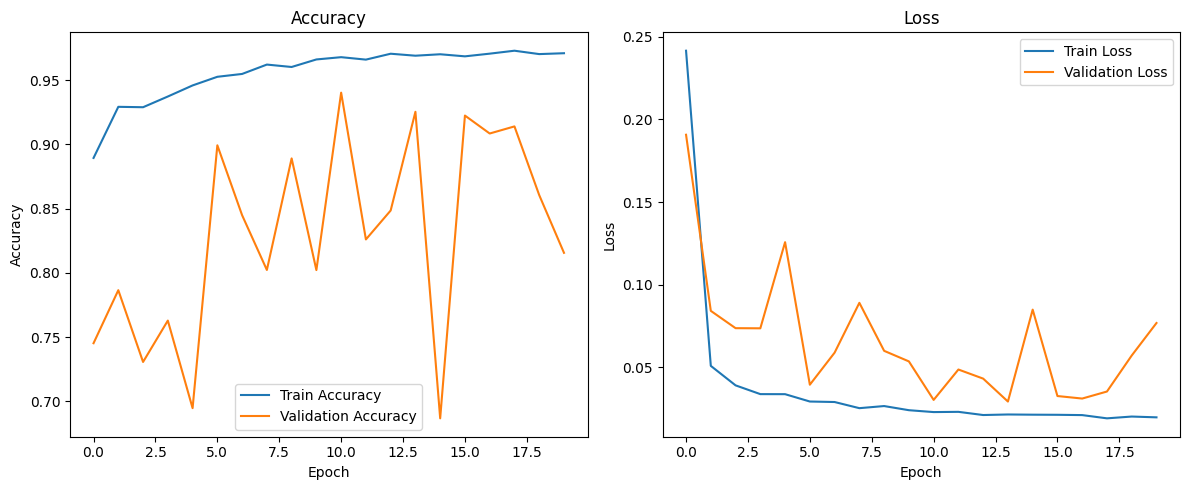

In [3]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/14_dense64_dropout0.3_training_plot.png")
plt.show()

              precision    recall  f1-score   support

      closed       0.73      1.00      0.84      4800
        open       1.00      0.63      0.77      4800

    accuracy                           0.82      9600
   macro avg       0.86      0.82      0.81      9600
weighted avg       0.86      0.82      0.81      9600



2025-06-13 17:19:54.353690: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16878262066570289699


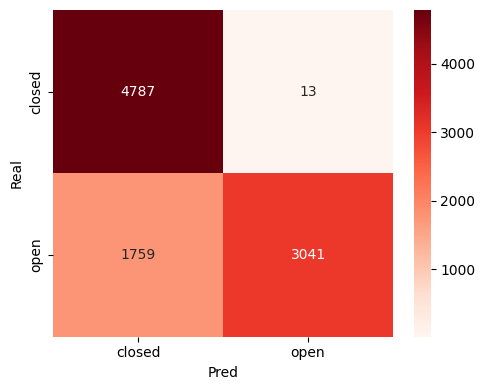

In [4]:
y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)

with open("../../results/reports/14_dense64_dropout0.3_classification_report.txt", "w") as f:
    f.write(report)

conf_matrix=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/14_dense64_dropout0.3_confusion_matrix.png")
plt.show()

모델이 여전히 closed에 과민반응, open class를 잘 못 잡고 있음  
다음에는 BatchNormalization 제거해보자  